# Exercise 3
## Part 1 
### Casey Allen
This notebook contains all numerical solutions to exercise 3, parts 1 and 2.

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

def solve_poisson(nx=128, ny=None, cg_order=1, visualize=True, save_vtk=False):
    """
    Solve the Poisson equation using two methods and compare results.
    
    Parameters:
    -----------
    nx       : Number of mesh cells in x-direction (default: 128)
    ny       : Number of mesh cells in y-direction (default: None, uses nx)
    cg_order : Order of continuous Galerkin elements (default: 1)
    visualize: Whether to create matplotlib plots (default: True)
    save_vtk : Whether to save VTK output for Paraview (default: True)
    
    Returns:
    --------
    dict : Dictionary containing solutions, errors, and mesh info
    """
    if ny is None:
        ny = nx
    
    # Create mesh
    mesh = UnitSquareMesh(nx, ny, quadrilateral=True)   #-------Creation of Mesh (step 3)
    
    # Function space with specified CG order
    V = FunctionSpace(mesh, 'CG', cg_order)
    
    # Spatial coordinates and source term
    x, y = SpatialCoordinate(mesh)
    f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y))
    
    # Exact solution for error computation
    u_exact = Function(V).interpolate(sin(pi*x)*cos(pi*y))
    
    # Boundary conditions
    bc_x0 = DirichletBC(V, Constant(0), 1)
    bc_x1 = DirichletBC(V, Constant(0), 2)
    bcs = [bc_x0, bc_x1]
    
    # ===== Method 1: Weak form manually constructed - Step 1: Weak formulation =====
    u = TrialFunction(V)
    du = TestFunction(V)              # Test function - equivalent to w(x,y)
    a = inner(grad(u), grad(du)) * dx # 
    L = f * du * dx
    u_1 = Function(V, name='Method_1_Manual')
    solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=bcs) # - Step 4
    
    # ===== Method 2: Variational principle via derivative - Step 2: Ritz-Galerkin/Variational principle =====
    u_2 = Function(V, name='Method_2_Variational') 
    Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f) * dx # Weak formulation - 1/2 int(gradU.gradDU - Uf)
    F = derivative(Ju, u_2, du)                         # Build algebraic system
    solve(F == 0, u_2, bcs=bcs)                         # Solve algebraic system - Step 4
    
    # ===== Error computation =====
    L2_1 = sqrt(assemble(dot(u_1 - u_exact, u_1 - u_exact) * dx))
    L2_2 = sqrt(assemble(dot(u_2 - u_exact, u_2 - u_exact) * dx))
    L2_diff = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx))
    
    # Print results
    print(f'\n{"="*60}')
    print(f'Mesh resolution: {nx}×{ny}, Δx = {1/nx:.6f}, CG order = {cg_order}')
    print(f'{"="*60}')
    print(f'L2 error (Method 1 vs exact): {L2_1:.6e}')
    print(f'L2 error (Method 2 vs exact): {L2_2:.6e}')
    print(f'L2 norm (Method 2 - Method 1): {L2_diff:.6e}')
    print(f'{"="*60}\n')
    
    # ===== Save VTK for Paraview =====
    if save_vtk:
        outfile = VTKFile(f'output_nx{nx}_cg{cg_order}.pvd')
        outfile.write(u_1, u_2, u_exact)
    
    # ===== Matplotlib visualization =====
    if visualize:
        plot_results(u_1, u_2, u_exact, nx, ny, cg_order)
    
    # Return results dictionary
    return {
        'u_1': u_1,
        'u_2': u_2,
        'u_exact': u_exact,
        'L2_error_method1': L2_1,
        'L2_error_method2': L2_2,
        'L2_difference': L2_diff,
        'mesh_resolution': (nx, ny),
        'cg_order': cg_order
    }

In [2]:
def plot_results(u_1, u_2, u_exact, nx, ny, cg_order):
    """
    Create contour plots of solutions and errors.
    """
    # Create a uniform grid for plotting (works for any CG order)
    n_points = 200  # Resolution for plotting
    x_plot = np.linspace(0, 1, n_points)
    y_plot = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x_plot, y_plot)
    
    # Evaluate functions at plot points
    points = np.column_stack([X.ravel(), Y.ravel()])
    
    try:
        u1_vals = np.array([u_1.at(p) for p in points]).reshape(X.shape)
        u2_vals = np.array([u_2.at(p) for p in points]).reshape(X.shape)
        exact_vals = np.array([u_exact.at(p) for p in points]).reshape(X.shape)
    except:
        # Fallback: use VTK interpolation (Sometimes dimension issue with higher CG order)
        from firedrake import Function, FunctionSpace
        V_plot = FunctionSpace(u_1.function_space().mesh(), 'CG', 1)
        u1_plot = Function(V_plot).interpolate(u_1)
        u2_plot = Function(V_plot).interpolate(u_2)
        exact_plot = Function(V_plot).interpolate(u_exact)
        
        u1_vals = np.array([u1_plot.at(p) for p in points]).reshape(X.shape)
        u2_vals = np.array([u2_plot.at(p) for p in points]).reshape(X.shape)
        exact_vals = np.array([exact_plot.at(p) for p in points]).reshape(X.shape)
    
    # Compute errors
    error_1 = u1_vals - exact_vals
    error_2 = u2_vals - exact_vals
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Poisson Equation Solution (Mesh: {nx}×{ny}, CG order: {cg_order})', 
                 fontsize=14, fontweight='bold')
    
    # Plot settings
    levels = 20
    
    # Row 1: Solutions
    cs1 = axes[0, 0].contourf(X, Y, u1_vals, levels=levels, cmap='viridis')
    axes[0, 0].set_title('Method 1: Manual Weak Form')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    axes[0, 0].set_aspect('equal')
    plt.colorbar(cs1, ax=axes[0, 0])
    
    cs2 = axes[0, 1].contourf(X, Y, u2_vals, levels=levels, cmap='viridis')
    axes[0, 1].set_title('Method 2: Variational Principle')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    axes[0, 1].set_aspect('equal')
    plt.colorbar(cs2, ax=axes[0, 1])
    
    cs3 = axes[0, 2].contourf(X, Y, exact_vals, levels=levels, cmap='viridis')
    axes[0, 2].set_title('Exact Solution')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    axes[0, 2].set_aspect('equal')
    plt.colorbar(cs3, ax=axes[0, 2])
    
    # Row 2: Errors
    cs4 = axes[1, 0].contourf(X, Y, error_1, levels=levels, cmap='RdBu_r')
    axes[1, 0].set_title('Error: Method 1 - Exact')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    axes[1, 0].set_aspect('equal')
    plt.colorbar(cs4, ax=axes[1, 0])
    
    cs5 = axes[1, 1].contourf(X, Y, error_2, levels=levels, cmap='RdBu_r')
    axes[1, 1].set_title('Error: Method 2 - Exact')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    axes[1, 1].set_aspect('equal')
    plt.colorbar(cs5, ax=axes[1, 1])
    
    # Difference between methods
    diff = u2_vals - u1_vals
    cs6 = axes[1, 2].contourf(X, Y, diff, levels=levels, cmap='RdBu_r')
    axes[1, 2].set_title('Difference: Method 2 - Method 1')
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    axes[1, 2].set_aspect('equal')
    plt.colorbar(cs6, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.savefig(f'poisson_solution_nx{nx}_cg{cg_order}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [3]:
def convergence_study(mesh_sizes=[16, 32, 64, 128], cg_order=1):
    """
    Perform a convergence study over multiple mesh resolutions.
    
    Parameters:
    -----------
    mesh_sizes : List of mesh resolutions to test
    cg_order   : Order of CG elements
    """
    errors_m1 = []
    errors_m2 = []
    h_values = []
    
    print("\nPerforming convergence study...")
    
    for nx in mesh_sizes:
        result = solve_poisson(nx=nx, cg_order=cg_order, visualize=False, save_vtk=False)
        errors_m1.append(result['L2_error_method1'])
        errors_m2.append(result['L2_error_method2'])
        h_values.append(1.0 / nx)
    
    # Plot convergence
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(h_values, errors_m1, 'o-', label='Method 1', linewidth=2, markersize=8)
    ax.loglog(h_values, errors_m2, 's-', label='Method 2', linewidth=2, markersize=8)
    
    # Reference lines
    ax.loglog(h_values, [h**(cg_order+1) * errors_m1[0] / h_values[0]**(cg_order+1) 
              for h in h_values], '--', label=f'O(h^{cg_order+1})', alpha=0.5)
    
    ax.set_xlabel('Mesh size h', fontsize=12)
    ax.set_ylabel('L2 Error', fontsize=12)
    ax.set_title(f'Convergence Study (CG order {cg_order})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'convergence_study_cg{cg_order}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return h_values, errors_m1, errors_m2


SINGLE SOLVE WITH VISUALIZATION

Mesh resolution: 64×64, Δx = 0.015625, CG order = 1
L2 error (Method 1 vs exact): 1.003464e-04
L2 error (Method 2 vs exact): 1.003464e-04
L2 norm (Method 2 - Method 1): 2.785399e-14



/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


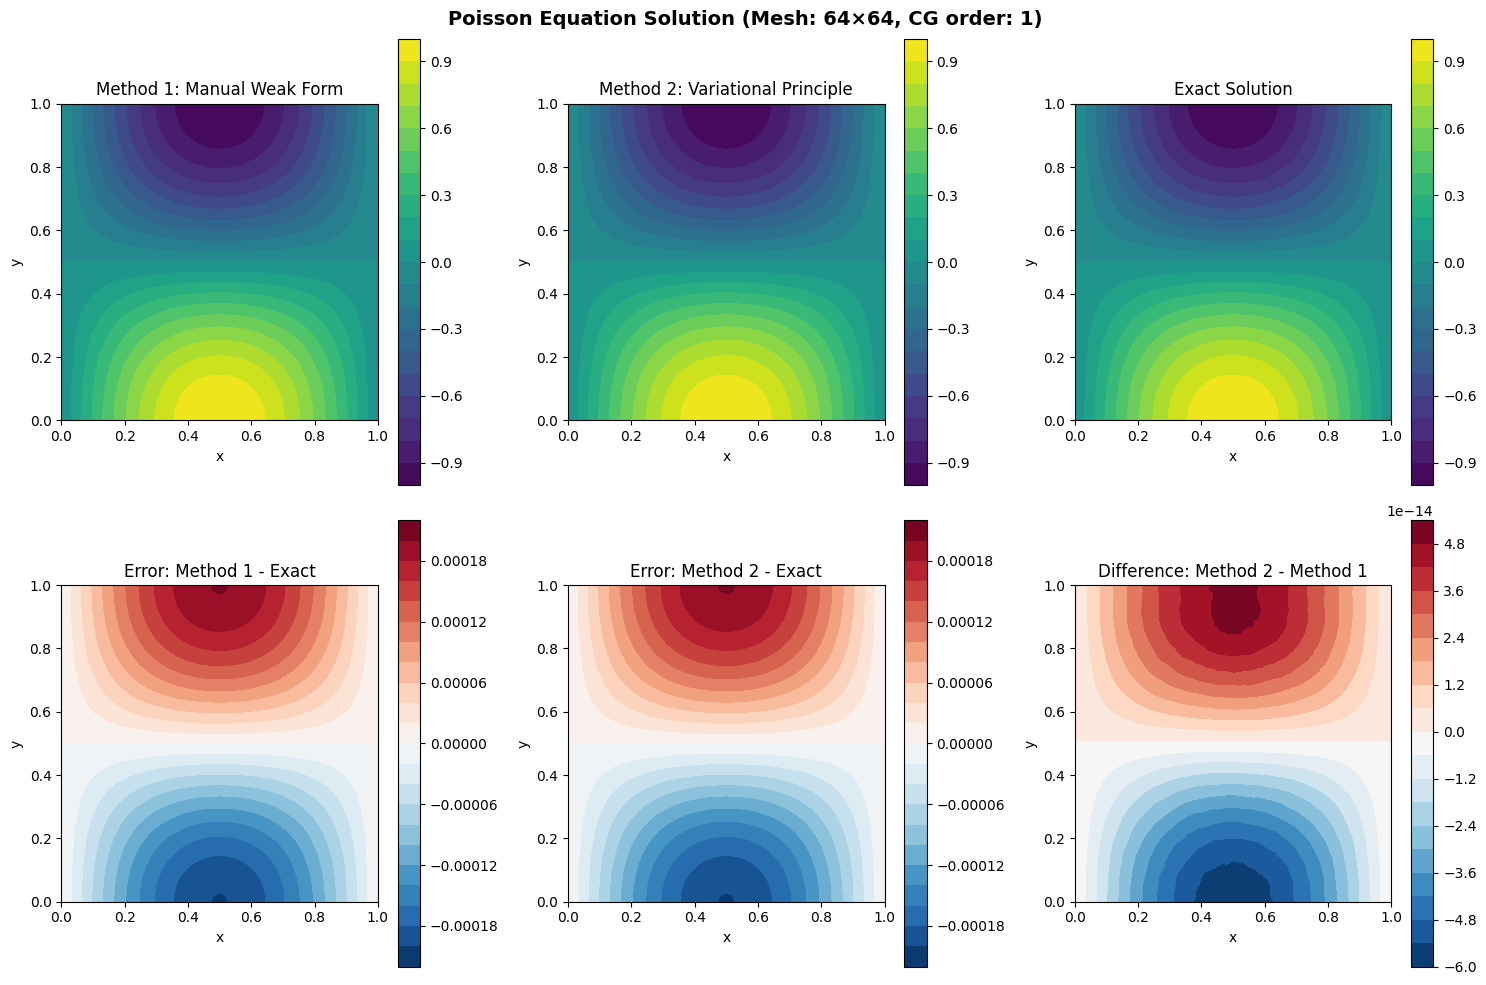


CONVERGENCE STUDY

Performing convergence study...

Mesh resolution: 16×16, Δx = 0.062500, CG order = 1
L2 error (Method 1 vs exact): 1.593011e-03
L2 error (Method 2 vs exact): 1.593011e-03
L2 norm (Method 2 - Method 1): 1.363591e-15


Mesh resolution: 32×32, Δx = 0.031250, CG order = 1
L2 error (Method 1 vs exact): 4.007573e-04
L2 error (Method 2 vs exact): 4.007573e-04
L2 norm (Method 2 - Method 1): 6.159062e-15


Mesh resolution: 64×64, Δx = 0.015625, CG order = 1
L2 error (Method 1 vs exact): 1.003464e-04
L2 error (Method 2 vs exact): 1.003464e-04
L2 norm (Method 2 - Method 1): 2.785399e-14


Mesh resolution: 128×128, Δx = 0.007812, CG order = 1
L2 error (Method 1 vs exact): 2.509643e-05
L2 error (Method 2 vs exact): 2.509643e-05
L2 norm (Method 2 - Method 1): 1.069251e-13



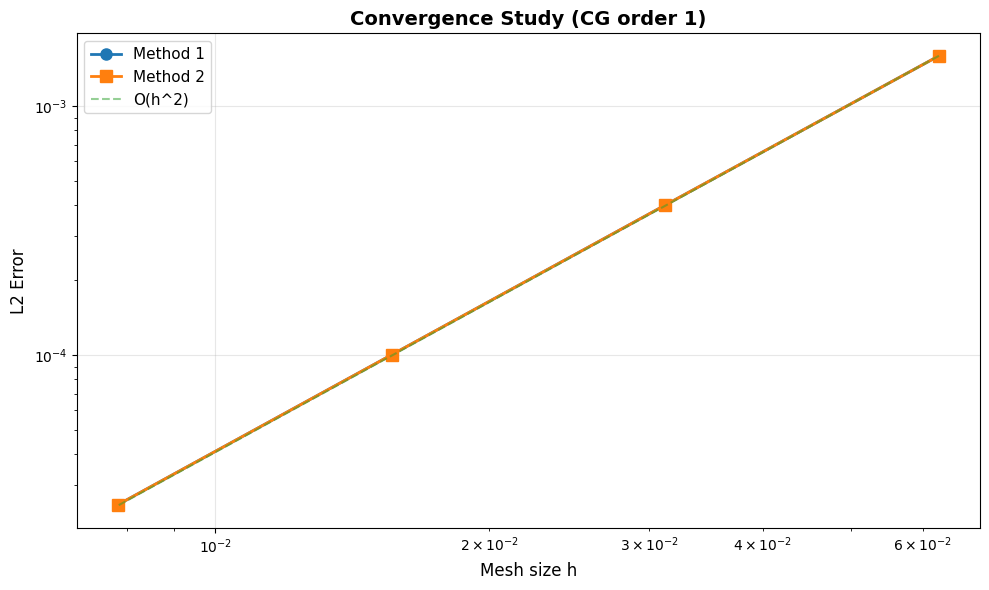


COMPARING DIFFERENT CG ORDERS

--- Testing CG order 2 ---

Mesh resolution: 32×32, Δx = 0.031250, CG order = 2
L2 error (Method 1 vs exact): 6.527732e-08
L2 error (Method 2 vs exact): 6.527729e-08
L2 norm (Method 2 - Method 1): 2.848572e-11



/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


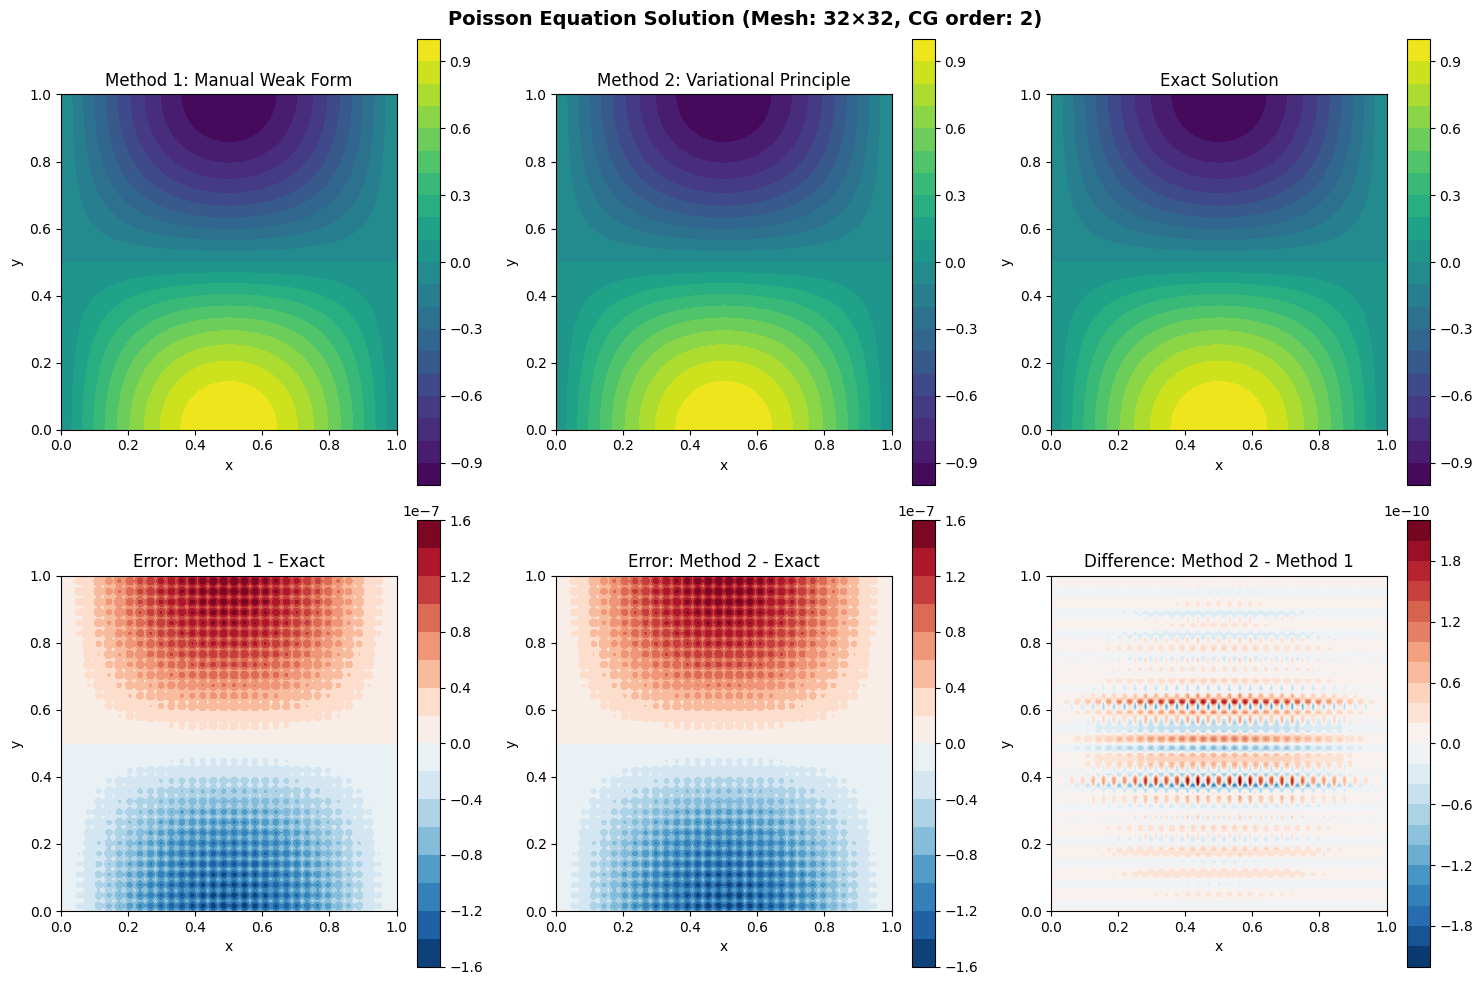


Performing convergence study...

Mesh resolution: 16×16, Δx = 0.062500, CG order = 2
L2 error (Method 1 vs exact): 1.042725e-06
L2 error (Method 2 vs exact): 1.042725e-06
L2 norm (Method 2 - Method 1): 6.279138e-11


Mesh resolution: 32×32, Δx = 0.031250, CG order = 2
L2 error (Method 1 vs exact): 6.527732e-08
L2 error (Method 2 vs exact): 6.527729e-08
L2 norm (Method 2 - Method 1): 2.848572e-11


Mesh resolution: 64×64, Δx = 0.015625, CG order = 2
L2 error (Method 1 vs exact): 4.081589e-09
L2 error (Method 2 vs exact): 4.081519e-09
L2 norm (Method 2 - Method 1): 3.039484e-12


Mesh resolution: 128×128, Δx = 0.007812, CG order = 2
L2 error (Method 1 vs exact): 2.554720e-10
L2 error (Method 2 vs exact): 2.551360e-10
L2 norm (Method 2 - Method 1): 2.377867e-12



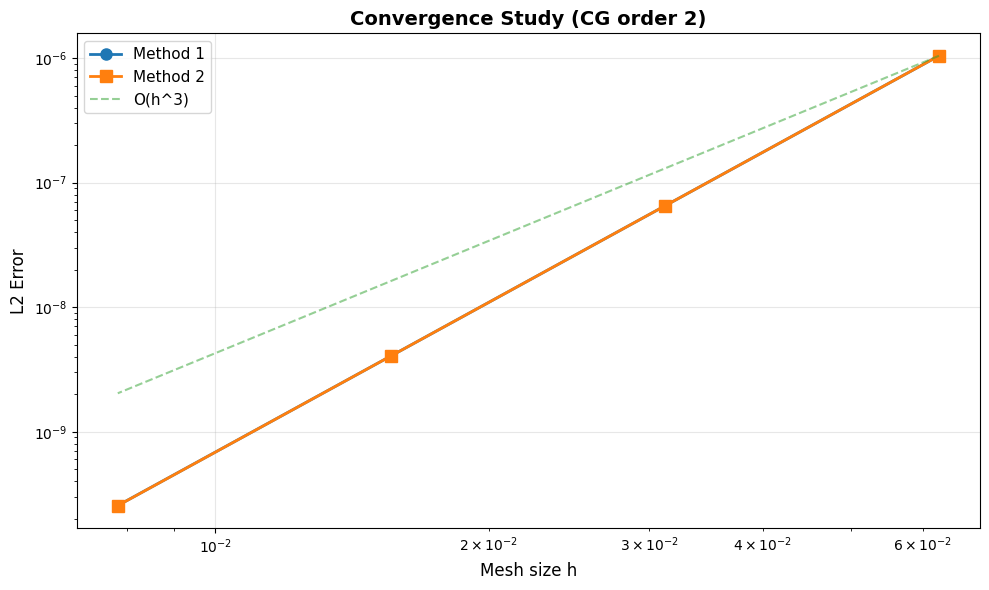


--- Testing CG order 3 ---

Mesh resolution: 32×32, Δx = 0.031250, CG order = 3
L2 error (Method 1 vs exact): 1.064388e-10
L2 error (Method 2 vs exact): 1.058576e-10
L2 norm (Method 2 - Method 1): 1.148145e-11



/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


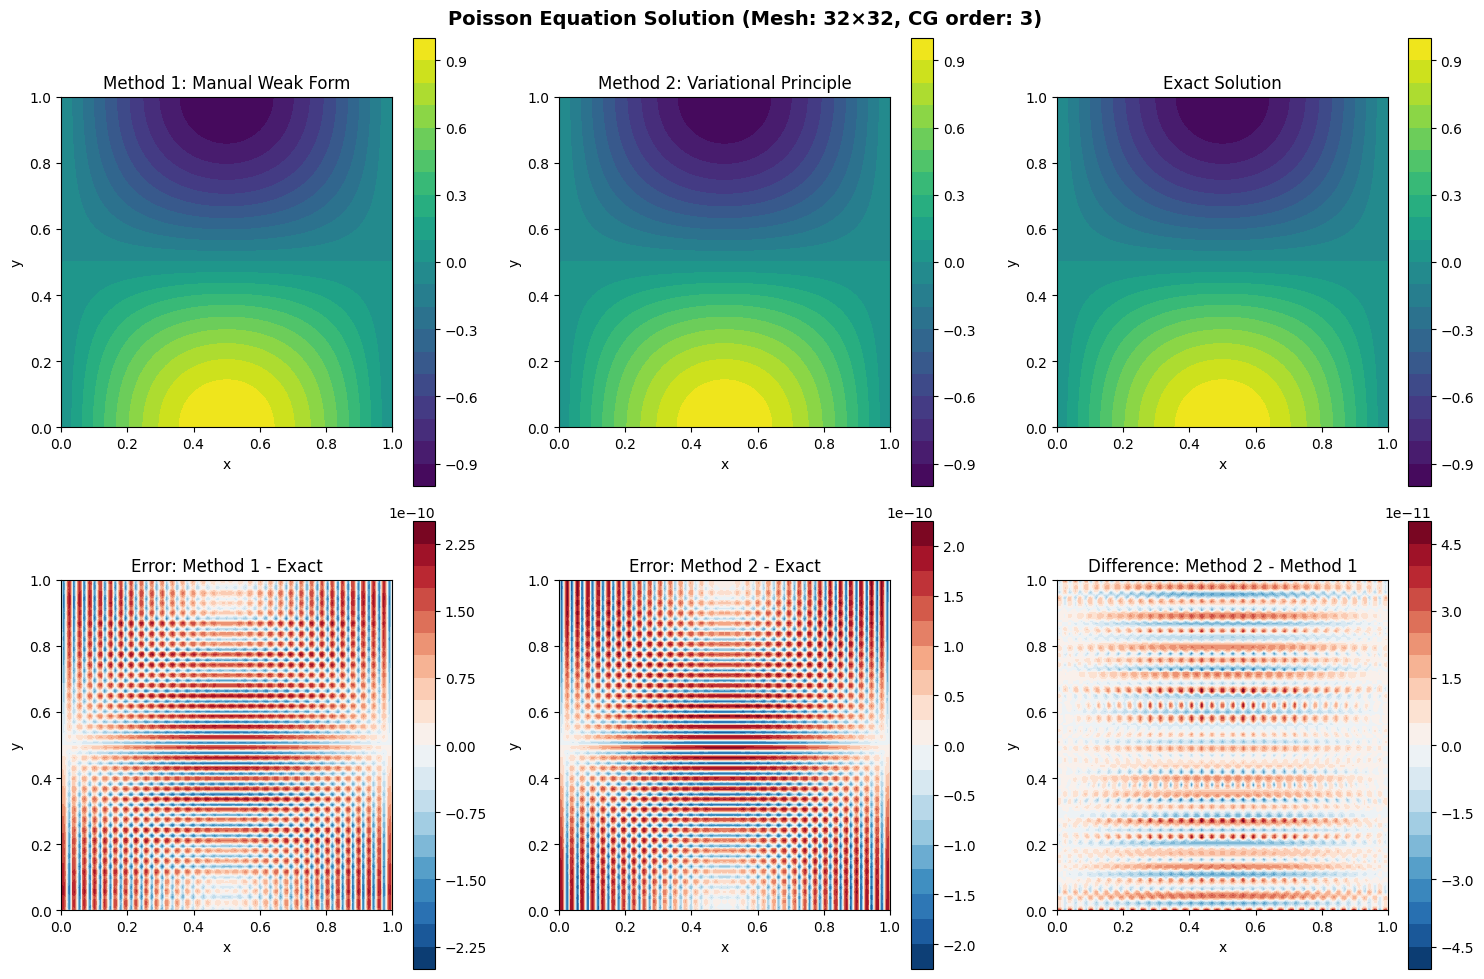


Performing convergence study...

Mesh resolution: 16×16, Δx = 0.062500, CG order = 3
L2 error (Method 1 vs exact): 3.382140e-09
L2 error (Method 2 vs exact): 3.378766e-09
L2 norm (Method 2 - Method 1): 3.051000e-11


Mesh resolution: 32×32, Δx = 0.031250, CG order = 3
L2 error (Method 1 vs exact): 1.064388e-10
L2 error (Method 2 vs exact): 1.058576e-10
L2 norm (Method 2 - Method 1): 1.148145e-11


Mesh resolution: 64×64, Δx = 0.015625, CG order = 3
L2 error (Method 1 vs exact): 5.348765e-12
L2 error (Method 2 vs exact): 3.340281e-12
L2 norm (Method 2 - Method 1): 4.244880e-12


Mesh resolution: 128×128, Δx = 0.007812, CG order = 3
L2 error (Method 1 vs exact): 2.184995e-12
L2 error (Method 2 vs exact): 2.053910e-12
L2 norm (Method 2 - Method 1): 1.091186e-12



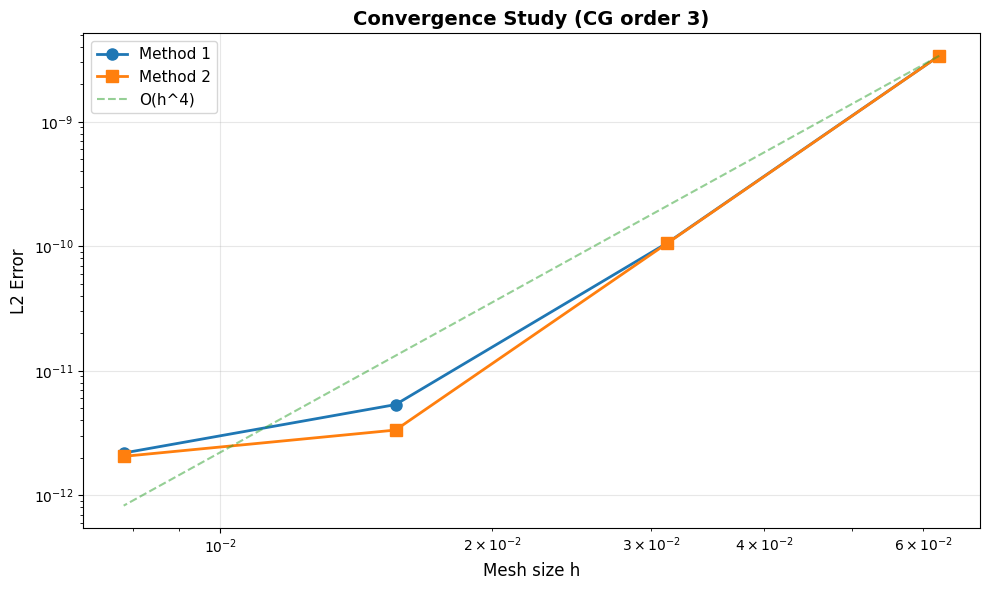

In [4]:
if __name__ == '__main__':
    # Choose what to run by setting these flags:
    RUN_SINGLE = True          # Single solve with visualization
    RUN_CONVERGENCE = True     # Convergence study
    RUN_CG_COMPARISON = True   # Compare CG orders
    
    if RUN_SINGLE:
        print("\n" + "="*60)
        print("SINGLE SOLVE WITH VISUALIZATION")
        print("="*60)
        result = solve_poisson(nx=64, cg_order=1, visualize=True, save_vtk=False)
    
    if RUN_CONVERGENCE:
        print("\n" + "="*60)
        print("CONVERGENCE STUDY")
        print("="*60)
        convergence_study(mesh_sizes=[16, 32, 64, 128], cg_order=1)
    
    if RUN_CG_COMPARISON:
        print("\n" + "="*60)
        print("COMPARING DIFFERENT CG ORDERS")
        print("="*60)
        for order in [2, 3]:
            print(f"\n--- Testing CG order {order} ---")
            solve_poisson(nx=32, cg_order=order, visualize=True, save_vtk=False)
            convergence_study(mesh_sizes=[16, 32, 64, 128], cg_order=order)

With increasing CG order, the solution is much closer to exact at each step x~10$^4$ smaller with each order increased, up to CG order 3 where the machine precision is reached, further reduction in mesh size would see this error remain the same, or possibly increase due to the summation of round-off errors through the numerous computations. The convergence with mesh size is also much more significant for each order, converging with an increased order wrt mesh size with each CG order increase. 

## 6

In [5]:
def solve_poisson(nx=128, ny=None, cg_order=1, visualize=True, save_vtk=False):
    """
    Solve the Poisson equation using two methods and compare results.
    
    Parameters:
    -----------
    nx       : Number of mesh cells in x-direction (default: 128)
    ny       : Number of mesh cells in y-direction (default: None, uses nx)
    cg_order : Order of continuous Galerkin elements (default: 1)
    visualize: Whether to create matplotlib plots (default: True)
    save_vtk : Whether to save VTK output for Paraview (default: True)
    
    Returns:
    --------
    dict : Dictionary containing solutions, errors, and mesh info
    """
    if ny is None:
        ny = nx
    
    # Create mesh
    mesh = UnitSquareMesh(nx, ny, quadrilateral=True)   #-------Creation of Mesh (step 3)
    
    # Function space with specified CG order
    V = FunctionSpace(mesh, 'CG', cg_order)
    
    # Spatial coordinates and source term
    x, y = SpatialCoordinate(mesh)
    
    #========= New function and BCs (and exact solution) ==========
    f = Function(V).interpolate(2*x*(y-1)*(y-2*x+x*y+2)*exp(x-y))
    u_exact = Function(V).interpolate(-x*(x-1)*y*(y-1)*exp(x-y))
    bc_bottom = DirichletBC(V, Constant(0), 3)
    bc_right  = DirichletBC(V, Constant(0), 2)
    bc_top    = DirichletBC(V, Constant(0), 4)
    bc_left   = DirichletBC(V, Constant(0), 1)
    bcs = [bc_bottom, bc_right, bc_top, bc_left]
    #==============================================================
    
    # ===== Method 1: Weak form manually constructed - Step 1: Weak formulation =====
    u = TrialFunction(V)
    du = TestFunction(V)              # Test function - equivalent to w(x,y)
    a = inner(grad(u), grad(du)) * dx # 
    L = f * du * dx
    u_1 = Function(V, name='Method_1_Manual')
    solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=bcs) # - Step 4
    
    # ===== Method 2: Variational principle via derivative - Step 2: Ritz-Galerkin/Variational principle =====
    u_2 = Function(V, name='Method_2_Variational') 
    Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f) * dx # Weak formulation - 1/2 int(gradU.gradDU - Uf)
    F = derivative(Ju, u_2, du)                         # Build algebraic system
    solve(F == 0, u_2, bcs=bcs)                         # Solve algebraic system - Step 4
    
    # ===== Error computation =====
    L2_1 = sqrt(assemble(dot(u_1 - u_exact, u_1 - u_exact) * dx))
    L2_2 = sqrt(assemble(dot(u_2 - u_exact, u_2 - u_exact) * dx))
    L2_diff = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx))
    
    # Print results
    print(f'\n{"="*60}')
    print(f'Mesh resolution: {nx}×{ny}, Δx = {1/nx:.6f}, CG order = {cg_order}')
    print(f'{"="*60}')
    print(f'L2 error (Method 1 vs exact): {L2_1:.6e}')
    print(f'L2 error (Method 2 vs exact): {L2_2:.6e}')
    print(f'L2 norm (Method 2 - Method 1): {L2_diff:.6e}')
    print(f'{"="*60}\n')
    
    # ===== Save VTK for Paraview =====
    if save_vtk:
        outfile = VTKFile(f'output_nx{nx}_cg{cg_order}.pvd')
        outfile.write(u_1, u_2, u_exact)
    
    # ===== Matplotlib visualization =====
    if visualize:
        plot_results(u_1, u_2, u_exact, nx, ny, cg_order)
    
    # Return results dictionary
    return {
        'u_1': u_1,
        'u_2': u_2,
        'u_exact': u_exact,
        'L2_error_method1': L2_1,
        'L2_error_method2': L2_2,
        'L2_difference': L2_diff,
        'mesh_resolution': (nx, ny),
        'cg_order': cg_order
    }


SINGLE SOLVE WITH VISUALIZATION

Mesh resolution: 64×64, Δx = 0.015625, CG order = 1
L2 error (Method 1 vs exact): 4.363992e-06
L2 error (Method 2 vs exact): 4.363993e-06
L2 norm (Method 2 - Method 1): 1.332624e-10



/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


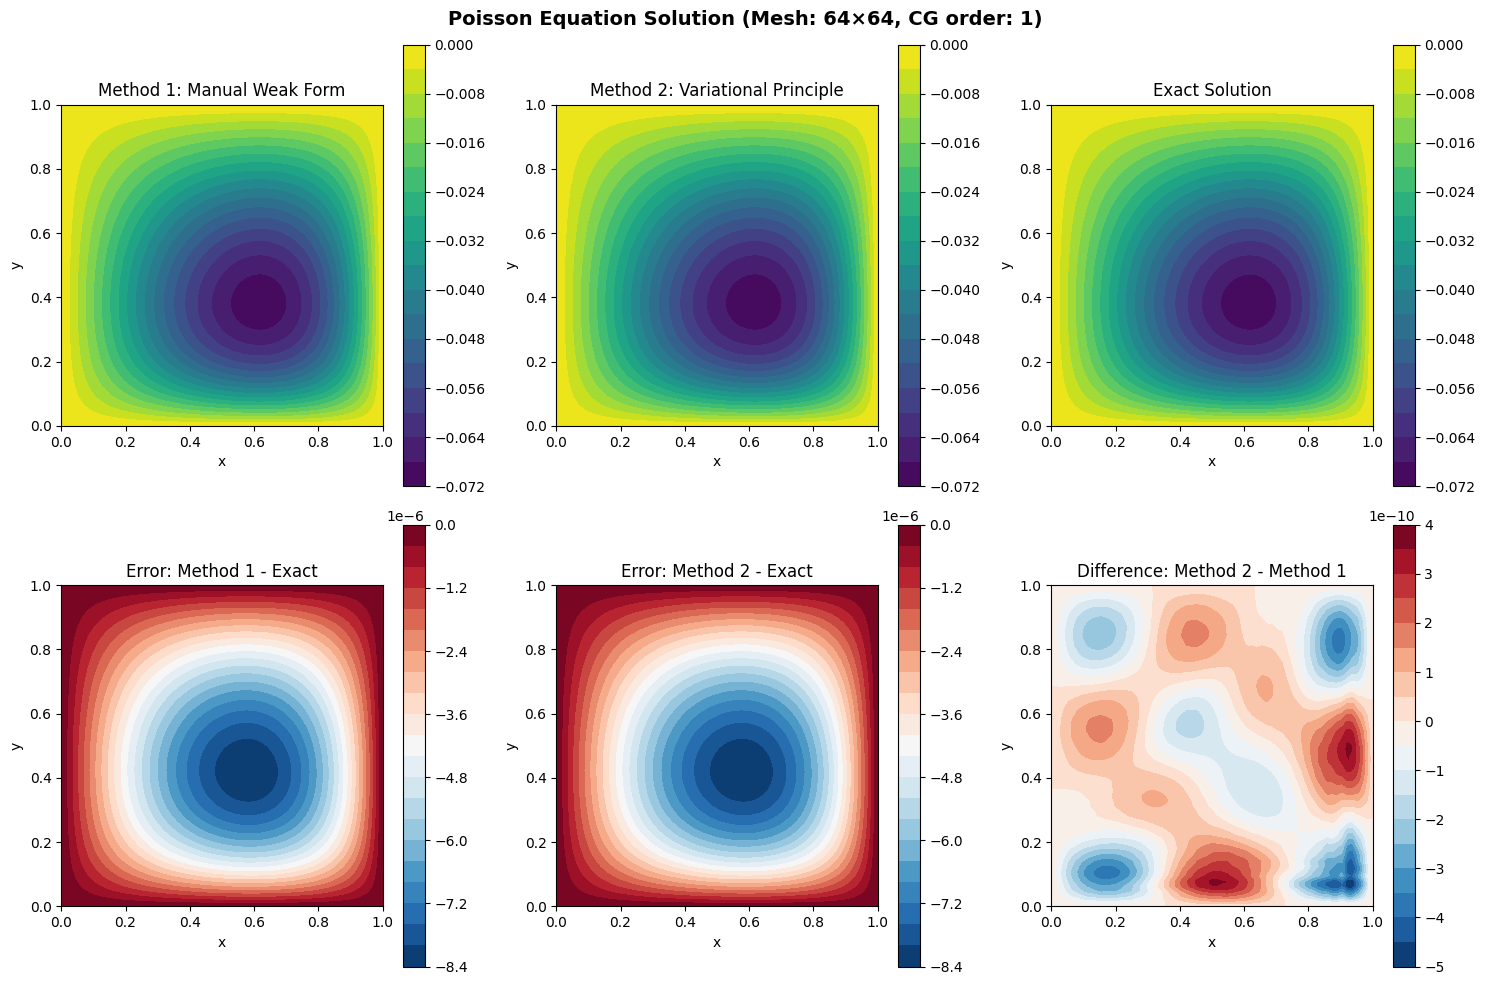

In [6]:
if __name__ == '__main__':
    # Choose what to run by setting these flags:
    RUN_SINGLE = True          # Single solve with visualization
    RUN_CONVERGENCE = False     # Convergence study
    RUN_CG_COMPARISON = False   # Compare CG orders
    
    if RUN_SINGLE:
        print("\n" + "="*60)
        print("SINGLE SOLVE WITH VISUALIZATION")
        print("="*60)
        result = solve_poisson(nx=64, cg_order=1, visualize=True, save_vtk=False)
    
    if RUN_CONVERGENCE:
        print("\n" + "="*60)
        print("CONVERGENCE STUDY")
        print("="*60)
        convergence_study(mesh_sizes=[16, 32, 64, 128], cg_order=1)
    
    if RUN_CG_COMPARISON:
        print("\n" + "="*60)
        print("COMPARING DIFFERENT CG ORDERS")
        print("="*60)
        for order in [2, 3]:
            print(f"\n--- Testing CG order {order} ---")
            solve_poisson(nx=32, cg_order=order, visualize=True, save_vtk=False)
            convergence_study(mesh_sizes=[16, 32, 64, 128], cg_order=order)

 Unsure what's causing the error to take the form it does here, whether caused by the error function or not but it is consistent through both methods (as it should be) and very small.
 NB: Convergence and CG order study not included here to shorten output but yields similar results to the previous example. Convergence is a little unusual for CG order 3, showing slower convergence than with the other problem. Change RUN_CONVERGENCE and RUN_CG_COMPARISON from False to True and run if you'd like to check those.

## Exercise 3 - Part 2

In [7]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time as tijd

def solve_groundwater_canal(m=20, nCG=3, theta=0.5, CFL=2.3, end_time=100.0, 
                            dt_output=2.0, dt_profile=10.0, rain_pattern='constant',
                            Rmax=0.000125, rain_duration=10.0, fixed_canal=False):
    """
    Solve coupled groundwater-canal system with variable rainfall.
    
    Parameters:
    -----------
    m : Number of mesh elements
    nCG : Order of CG elements
    theta : Crank-Nicolson parameter (0.5 for CN, 1.0 for implicit, 0.0 for explicit)
    CFL : CFL number for timestep
    end_time : End time of simulation
    dt_output : Output interval for hcm and R(t)
    dt_profile : Output interval for hm profiles
    rain_pattern : 'constant', 'intermittent_1', 'intermittent_2', 'intermittent_4', 'intermittent_9'
    Rmax : Maximum rain rate
    rain_duration : Duration of rain cycle (default 10s)
    fixed_canal : If True, fix hcm = 0.07m (simpler problem)
    
    Returns:
    --------
    dict : Solution data and mesh information
    """
    
    # Mesh setup
    Ly = 0.85
    dy = Ly/m
    mesh = IntervalMesh(m, 0, Ly)
    y, = SpatialCoordinate(mesh)
    
    # Function space
    V = FunctionSpace(mesh, "CG", nCG)
    
    # Timestep
    Dt = CFL * 0.5 * dy * dy
    dt = Constant(Dt)
    
    # Physical parameters
    mpor = 0.3
    sigma = 0.8
    Lc = 0.05
    kperm = 1e-8
    nu = 1.0e-6
    g = 9.81
    alpha = kperm / (nu * mpor * sigma)
    gam = Lc / (mpor * sigma)
    fac2 = sqrt(g) / (mpor * sigma)
    
    # Rain function
    def get_rain_rate(t_current):
        """Get rain rate at current time based on pattern"""
        if rain_pattern == 'constant':
            return Rmax
        elif rain_pattern.startswith('intermittent'):
            # Extract duration from pattern name
            duration_map = {
                'intermittent_1': 1.0,
                'intermittent_2': 2.0,
                'intermittent_4': 4.0,
                'intermittent_9': 9.0
            }
            rain_on_duration = duration_map.get(rain_pattern, 0.0)
            cycle_time = t_current % rain_duration
            return Rmax if cycle_time < rain_on_duration else 0.0
        else:
            return Rmax
    
    # Initial conditions
    h_prev = Function(V, name="hm").interpolate(0.0 + 0.0*y)  # hm(y, 0) = 0
    hcm_prev = 0.0  # hcm(0) = 0
    
    # Storage for time series
    times = []
    hcm_values = []
    R_values = []
    hm_profiles = []
    profile_times = []
    
    # Create output file
    outfile = VTKFile("./Results/groundwater_canal.pvd")
    
    # Flux function
    def flux(h, phi, R_current):
        return (alpha * g * h * dot(grad(h), grad(phi)) - 
                (R_current * phi) / (mpor * sigma))
    
    # Setup solver
    t = 0.0
    t_next_output = dt_output
    t_next_profile = dt_profile
    t_next_print = 10.0  # Print every 10 seconds
    
    print(f"\n{'='*70}")
    print(f"Groundwater-Canal System Simulation")
    print(f"{'='*70}")
    print(f"Mesh elements: {m}, CG order: {nCG}, theta: {theta}")
    print(f"Timestep: {Dt:.6e} s, End time: {end_time} s")
    print(f"Rain pattern: {rain_pattern}, Rmax: {Rmax}")
    print(f"Fixed canal: {fixed_canal}")
    print(f"{'='*70}\n")
    
    # Initial output
    times.append(0.0)
    hcm_values.append(hcm_prev)
    R_values.append(get_rain_rate(0.0))
    hm_profiles.append(h_prev.dat.data.copy())
    profile_times.append(0.0)
    outfile.write(h_prev, time=0.0)
    
    # Time stepping
    step = 0
    start_time = tijd.time()
    
    if fixed_canal:
        # Simpler problem with fixed canal height
        hcm_fixed = 0.07
        h = Function(V)
        h.assign(h_prev)
        
        while t < end_time:
            t += Dt
            step += 1
            
            R_current = get_rain_rate(t)
            
            # Variational formulation
            phi = TestFunction(V)
            F = ((h - h_prev) * phi / dt + 
                 theta * flux(h, phi, R_current) + 
                 (1 - theta) * flux(h_prev, phi, R_current)) * dx
            
            # Dirichlet BC at y=0
            bc1 = DirichletBC(V, hcm_fixed, 1)
            
            # Solve
            solve(F == 0, h, bcs=bc1, 
                  solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
            
            h_prev.assign(h)
            hcm_current = hcm_fixed
            
            # Store outputs
            if t >= t_next_output:
                times.append(t)
                hcm_values.append(hcm_current)
                R_values.append(R_current)
                t_next_output += dt_output
                
            if t >= t_next_profile:
                hm_profiles.append(h_prev.dat.data.copy())
                profile_times.append(t)
                t_next_profile += dt_profile
                print(f"t = {t:.2f}s, hcm = {hcm_current:.6f}m, R = {R_current:.6e}")
                outfile.write(h_prev, time=t)
    
    else:
        # Full problem with canal equation
        hcm_current = hcm_prev
        
        # Setup variational problem once (outside loop for efficiency)
        phi = TestFunction(V)
        R_const = Constant(Rmax)  # Use Constant for efficient updating
        
        if theta == 0.0:
            # EXPLICIT scheme with weir boundary
            h, out = TrialFunction(V), Function(V)
            out.assign(h_prev)
            
            aa = (h * phi / dt) * dx + (gam * phi * h / dt) * ds(1)
            L = (h_prev * phi / dt - flux(h_prev, phi, R_const)) * dx
            L += (gam * phi * h_prev / dt - phi * fac2 * max_value(2.0*h_prev/3.0, 0.0)**1.5) * ds(1)
            
            # Create problem and solver once
            problem = LinearVariationalProblem(aa, L, out)
            solver = LinearVariationalSolver(problem,
                                            solver_parameters={'mat_type': 'aij',
                                                             'ksp_type': 'preonly', 
                                                             'pc_type': 'lu',
                                                             'pc_factor_mat_solver_type': 'mumps',
                                                             'ksp_rtol': 1e-14})
            
            while t < end_time:
                t += Dt
                step += 1
                
                R_current = get_rain_rate(t)
                R_const.assign(R_current)
                
                # Solve groundwater equation
                solver.solve()
                
                # Update canal height using canal equation
                h_at_boundary = out.dat.data[0]
                q_in = fac2 * max(2.0 * h_at_boundary / 3.0, 0.0)**1.5
                q_out = fac2 * max(2.0 * hcm_current / 3.0, 0.0)**1.5
                
                dhcm_dt = (q_in - q_out) / Lc
                hcm_current = hcm_prev + dhcm_dt * Dt
                hcm_current = max(hcm_current, 0.0)
                
                # Update for next timestep
                h_prev.assign(out)
                hcm_prev = hcm_current
                
                # Store outputs
                if t >= t_next_output - 1e-10:
                    times.append(t)
                    hcm_values.append(hcm_current)
                    R_values.append(R_current)
                    t_next_output += dt_output
                    
                if t >= t_next_profile - 1e-10:
                    hm_profiles.append(h_prev.dat.data.copy())
                    profile_times.append(t)
                    outfile.write(h_prev, time=t)
                    t_next_profile += dt_profile
                
                # Print output every 10 seconds
                if t >= t_next_print - 1e-10:
                    print(f"t = {t:.2f}s, hcm = {hcm_current:.6f}m, R = {R_current:.6e}")
                    t_next_print += 10.0
                    
        else:
            # IMPLICIT/CRANK-NICOLSON scheme with weir boundary - Newton iteration
            h = Function(V)
            h.assign(h_prev)
            
            F = ((h - h_prev) * phi / dt + 
                 theta * flux(h, phi, R_const) + 
                 (1 - theta) * flux(h_prev, phi, R_const)) * dx
            
            # Boundary contribution at y=0 with weir equation
            F_boundary = (gam * phi * (h - h_prev) / dt + 
                         theta * phi * fac2 * max_value(2.0 * h / 3.0, 0.0)**1.5 +
                         (1 - theta) * phi * fac2 * max_value(2.0 * h_prev / 3.0, 0.0)**1.5) * ds(1)
            
            # Create problem and solver once
            problem = NonlinearVariationalProblem(F + F_boundary, h)
            solver = NonlinearVariationalSolver(problem,
                                               solver_parameters={'mat_type': 'aij',
                                                                'ksp_type': 'preonly', 
                                                                'pc_type': 'lu',
                                                                'pc_factor_mat_solver_type': 'mumps',
                                                                'ksp_rtol': 1e-14})
            
            while t < end_time:
                t += Dt
                step += 1
                
                R_current = get_rain_rate(t)
                R_const.assign(R_current)
                
                # Solve groundwater equation
                solver.solve()
                
                # Update canal height using canal equation
                h_at_boundary = h.dat.data[0]
                q_in = fac2 * max(2.0 * h_at_boundary / 3.0, 0.0)**1.5
                q_out = fac2 * max(2.0 * hcm_current / 3.0, 0.0)**1.5
                
                dhcm_dt = (q_in - q_out) / Lc
                hcm_current = hcm_prev + dhcm_dt * Dt
                hcm_current = max(hcm_current, 0.0)
                
                # Update for next timestep
                h_prev.assign(h)
                hcm_prev = hcm_current
                
                # Store outputs
                if t >= t_next_output - 1e-10:
                    times.append(t)
                    hcm_values.append(hcm_current)
                    R_values.append(R_current)
                    t_next_output += dt_output
                    
                if t >= t_next_profile - 1e-10:
                    hm_profiles.append(h_prev.dat.data.copy())
                    profile_times.append(t)
                    outfile.write(h_prev, time=t)
                    t_next_profile += dt_profile
                
                # Print output every 10 seconds
                if t >= t_next_print - 1e-10:
                    print(f"t = {t:.2f}s, hcm = {hcm_current:.6f}m, R = {R_current:.6e}")
                    t_next_print += 10.0
    
    elapsed_time = tijd.time() - start_time
    print(f"\n{'='*70}")
    print(f"Simulation completed in {elapsed_time:.2f} seconds ({step} steps)")
    print(f"Final time: {t:.2f}s")
    print(f"Final hcm: {hcm_values[-1]:.6f}m")
    print(f"Final hm at y=Ly: {h_prev.dat.data[-1]:.6f}m")
    print(f"{'='*70}\n")
    
    # Get mesh coordinates
    y_dofs = Function(V).interpolate(y).dat.data.copy()
    
    return {
        'times': np.array(times),
        'hcm': np.array(hcm_values),
        'R': np.array(R_values),
        'hm_profiles': hm_profiles,
        'profile_times': profile_times,
        'y_coords': y_dofs,
        'final_hm': h_prev.dat.data.copy(),
        'mesh_size': m,
        'cg_order': nCG,
        'timestep': Dt,
        'rain_pattern': rain_pattern
    }


def plot_results(result, save_prefix=''):
    """Plot time series and profiles"""
    
    fig = plt.figure(figsize=(16, 10))
    
    # Time series plots
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(result['times'], result['hcm'], 'b-', linewidth=2)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Canal height hcm (m)', fontsize=12)
    ax1.set_title('Canal Height vs Time', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(result['times'], result['R'], 'r-', linewidth=2)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel('Rain rate R (m/s)', fontsize=12)
    ax2.set_title('Rain Rate vs Time', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Profiles at different times
    ax3 = plt.subplot(2, 3, 3)
    cmap = plt.cm.viridis
    colors = [cmap(i/len(result['profile_times'])) for i in range(len(result['profile_times']))]
    
    for i, (hm, t) in enumerate(zip(result['hm_profiles'], result['profile_times'])):
        ax3.plot(result['y_coords'], hm, color=colors[i], 
                label=f't={t:.0f}s', linewidth=1.5)
    
    ax3.set_xlabel('Position y (m)', fontsize=12)
    ax3.set_ylabel('Groundwater height hm (m)', fontsize=12)
    ax3.set_title('Groundwater Profiles', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)
    
    # Final profile detail
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(result['y_coords'], result['final_hm'], 'b-', linewidth=2, marker='o', markersize=4)
    ax4.set_xlabel('Position y (m)', fontsize=12)
    ax4.set_ylabel('Groundwater height hm (m)', fontsize=12)
    ax4.set_title(f'Final Profile at t={result["times"][-1]:.0f}s', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Combined plot: hcm and R
    ax5 = plt.subplot(2, 3, 5)
    ax5_twin = ax5.twinx()
    
    l1 = ax5.plot(result['times'], result['hcm'], 'b-', linewidth=2, label='hcm')
    l2 = ax5_twin.plot(result['times'], result['R'], 'r-', linewidth=2, label='R')
    
    ax5.set_xlabel('Time (s)', fontsize=12)
    ax5.set_ylabel('Canal height hcm (m)', fontsize=12, color='b')
    ax5_twin.set_ylabel('Rain rate R (m/s)', fontsize=12, color='r')
    ax5.tick_params(axis='y', labelcolor='b')
    ax5_twin.tick_params(axis='y', labelcolor='r')
    ax5.set_title('Canal & Rain vs Time', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Info text
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    info_text = f"""
    Simulation Parameters:
    ━━━━━━━━━━━━━━━━━━━━━
    Mesh elements: {result['mesh_size']}
    CG order: {result['cg_order']}
    Timestep: {result['timestep']:.6e} s
    Rain pattern: {result['rain_pattern']}
    
    Final Results (t={result['times'][-1]:.1f}s):
    ━━━━━━━━━━━━━━━━━━━━━
    Final hcm: {result['hcm'][-1]:.6f} m
    Final hm(0): {result['final_hm'][0]:.6f} m
    Final hm(Ly): {result['final_hm'][-1]:.6f} m
    
    Steady State Check:
    ━━━━━━━━━━━━━━━━━━━━━
    Δhcm (last 20s): {abs(result['hcm'][-1] - result['hcm'][-10]):.6e} m
    """
    
    ax6.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f'Groundwater-Canal System: {result["rain_pattern"]}', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_{result["rain_pattern"]}.png', dpi=150, bbox_inches='tight')
    
    plt.show()

In [24]:
def convergence_study(mesh_sizes, fixed_canal=True, theta=0.5):
    """Study mesh convergence"""
    
    print("\n" + "="*70)
    print("CONVERGENCE STUDY")
    print("="*70 + "\n")
    
    solutions = []
    errors = []
    h_values = []
    
    # Reference solution (finest mesh)
    print("Computing reference solution (m=160)...")
    ref_result = solve_groundwater_canal(m=160, nCG=3, theta=theta, end_time=10.0, 
                                         dt_output=10.0, dt_profile=10.0,
                                         fixed_canal=fixed_canal)
    
    print("\nComputing solutions for convergence study:")
    for m in mesh_sizes:
        print(f"\nSolving with m={m}...")
        result = solve_groundwater_canal(m=m, nCG=3, theta=theta, end_time=10.0,
                                        dt_output=10.0, dt_profile=10.0,
                                        fixed_canal=fixed_canal)
        
        # Interpolate to common grid for comparison
        y_ref = ref_result['y_coords']
        y_test = result['y_coords']
        hm_ref = ref_result['final_hm']
        hm_test = np.interp(y_ref, y_test, result['final_hm'])
        
        # Compute L2 error
        error = np.sqrt(np.trapz((hm_test - hm_ref)**2, y_ref))
        errors.append(error)
        h_values.append(1.0/m)
        solutions.append(result)
        
        print(f"  Mesh {m}: L2 error = {error:.6e}, final hcm = {result['hcm'][-1]:.6f}")
    
    # Plot convergence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Convergence plot
    ax1.loglog(h_values, errors, 'o-', linewidth=2, markersize=8, label='Computed error')
    
    # Reference lines for different orders
    if len(errors) >= 2:
        # Estimate convergence rate
        rate = np.log(errors[-1]/errors[0]) / np.log(h_values[-1]/h_values[0])
        print(f"\nEstimated convergence rate: {rate:.2f}")
        
        # Plot reference line with estimated rate
        ax1.loglog(h_values, [errors[0] * (h/h_values[0])**2 for h in h_values], 
                  '--', label='O(h²)', alpha=0.5, color='red')
        ax1.loglog(h_values, [errors[0] * (h/h_values[0])**rate for h in h_values],
                  ':', label=f'O(h^{rate:.2f})', alpha=0.7, color='green')
    
    ax1.set_xlabel('Mesh size h', fontsize=12)
    ax1.set_ylabel('L2 Error', fontsize=12)
    ax1.set_title(f'Convergence Study at t=100s (θ={theta})', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Compare final profiles
    for result in solutions:
        ax2.plot(result['y_coords'], result['final_hm'], 
                label=f'm={result["mesh_size"]}', linewidth=2)
    
    # Add reference solution
    ax2.plot(ref_result['y_coords'], ref_result['final_hm'],
            'k--', label='Reference (m=160)', linewidth=2, alpha=0.5)
    
    ax2.set_xlabel('Position y (m)', fontsize=12)
    ax2.set_ylabel('hm (m)', fontsize=12)
    ax2.set_title('Final Profiles (t=100s)', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'convergence_study_theta{theta}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("CONVERGENCE STUDY COMPLETE")
    print("="*70)
    
    return solutions, errors, h_values

In [9]:
def compare_rain_patterns():
    """Compare different rain patterns"""
    
    print("\n" + "="*70)
    print("COMPARING RAIN PATTERNS")
    print("="*70 + "\n")
    
    patterns = ['constant', 'intermittent_1', 'intermittent_2', 
                'intermittent_4', 'intermittent_9']
    
    results = {}
    
    for pattern in patterns:
        print(f"\nSolving with pattern: {pattern}")
        result = solve_groundwater_canal(m=40, nCG=3, end_time=100.0,
                                        dt_output=2.0, dt_profile=10.0,
                                        rain_pattern=pattern, fixed_canal=False)
        results[pattern] = result
    
    # Comparative plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Canal height comparison
    ax1 = axes[0, 0]
    for pattern, result in results.items():
        label = pattern.replace('intermittent_', '').replace('constant', 'constant (10/10s)')
        if pattern != 'constant':
            label = label + '/10s'
        ax1.plot(result['times'], result['hcm'], linewidth=2, label=label)
    
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Canal height hcm (m)', fontsize=12)
    ax1.set_title('Canal Height: Different Rain Patterns', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Rain patterns
    ax2 = axes[0, 1]
    for pattern, result in results.items():
        label = pattern.replace('intermittent_', '').replace('constant', 'constant')
        if pattern != 'constant':
            label = label + '/10s'
        ax2.plot(result['times'], result['R'], linewidth=2, label=label, alpha=0.7)
    
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.set_ylabel('Rain rate R (m/s)', fontsize=12)
    ax2.set_title('Rain Patterns', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Final profiles
    ax3 = axes[1, 0]
    for pattern, result in results.items():
        label = pattern.replace('intermittent_', '').replace('constant', 'constant')
        if pattern != 'constant':
            label = label + '/10s'
        ax3.plot(result['y_coords'], result['final_hm'], linewidth=2, label=label)
    
    ax3.set_xlabel('Position y (m)', fontsize=12)
    ax3.set_ylabel('hm (m)', fontsize=12)
    ax3.set_title('Final Groundwater Profiles (t=100s)', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Steady state analysis
    ax4 = axes[1, 1]
    steady_state_hcm = []
    patterns_labels = []
    
    for pattern, result in results.items():
        # Average over last 20 seconds
        mask = result['times'] >= 80.0
        ss_value = np.mean(result['hcm'][mask])
        steady_state_hcm.append(ss_value)
        
        label = pattern.replace('intermittent_', '').replace('constant', '10/10')
        if pattern != 'constant':
            label = label + '/10'
        patterns_labels.append(label)
    
    ax4.bar(patterns_labels, steady_state_hcm, alpha=0.7, edgecolor='black')
    ax4.set_ylabel('Steady-state hcm (m)', fontsize=12)
    ax4.set_xlabel('Rain pattern (s)', fontsize=12)
    ax4.set_title('Steady-State Canal Heights', fontsize=13, fontweight='bold')
    ax4.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rain_pattern_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return results


SIMPLE PROBLEM: FIXED CANAL HEIGHT (hcm = 0.07m)

Groundwater-Canal System Simulation
Mesh elements: 40, CG order: 3, theta: 0.5
Timestep: 5.192969e-04 s, End time: 100.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: True

t = 10.00s, hcm = 0.070000m, R = 1.250000e-04
t = 20.00s, hcm = 0.070000m, R = 1.250000e-04
t = 30.00s, hcm = 0.070000m, R = 1.250000e-04
t = 40.00s, hcm = 0.070000m, R = 1.250000e-04
t = 50.00s, hcm = 0.070000m, R = 1.250000e-04
t = 60.00s, hcm = 0.070000m, R = 1.250000e-04
t = 70.00s, hcm = 0.070000m, R = 1.250000e-04
t = 80.00s, hcm = 0.070000m, R = 1.250000e-04
t = 90.00s, hcm = 0.070000m, R = 1.250000e-04
t = 100.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 1180.90 seconds (192569 steps)
Final time: 100.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.076287m



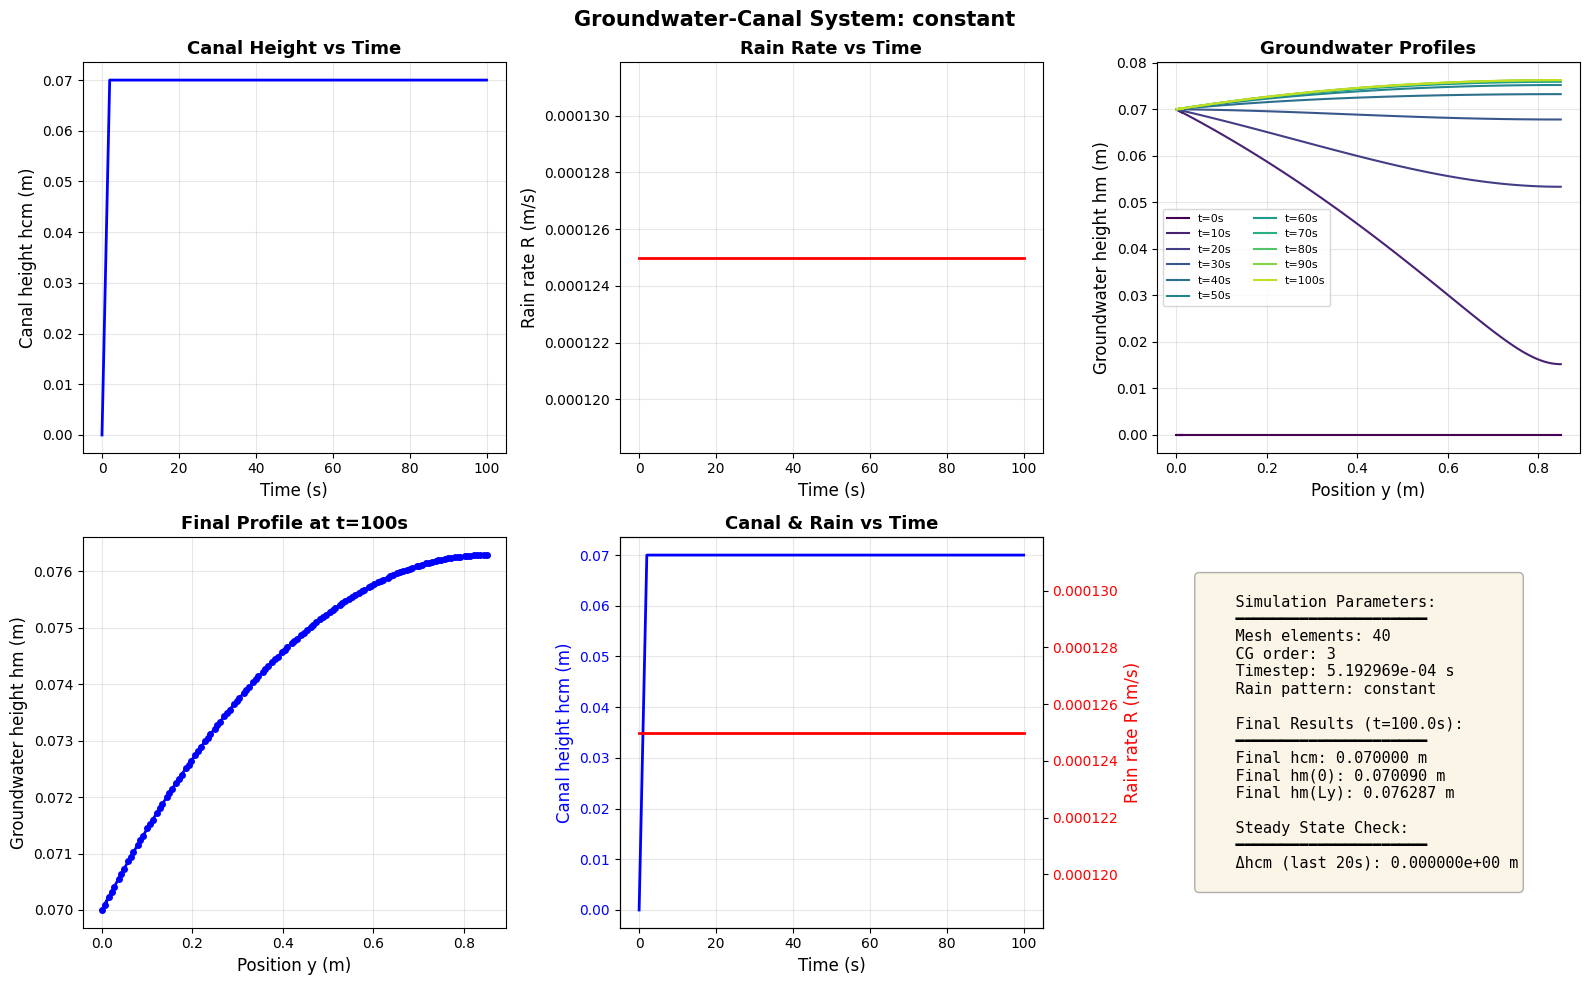


FULL PROBLEM: COUPLED GROUNDWATER-CANAL

Groundwater-Canal System Simulation
Mesh elements: 40, CG order: 3, theta: 0.5
Timestep: 5.192969e-04 s, End time: 100.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: False

t = 10.00s, hcm = 0.001293m, R = 1.250000e-04
t = 20.00s, hcm = 0.001875m, R = 1.250000e-04
t = 30.00s, hcm = 0.002324m, R = 1.250000e-04
t = 40.00s, hcm = 0.002702m, R = 1.250000e-04
t = 50.00s, hcm = 0.003018m, R = 1.250000e-04
t = 60.00s, hcm = 0.003266m, R = 1.250000e-04
t = 70.00s, hcm = 0.003453m, R = 1.250000e-04
t = 80.00s, hcm = 0.003589m, R = 1.250000e-04
t = 90.00s, hcm = 0.003685m, R = 1.250000e-04
t = 100.00s, hcm = 0.003753m, R = 1.250000e-04

Simulation completed in 183.35 seconds (192569 steps)
Final time: 100.00s
Final hcm: 0.003753m
Final hm at y=Ly: 0.029099m



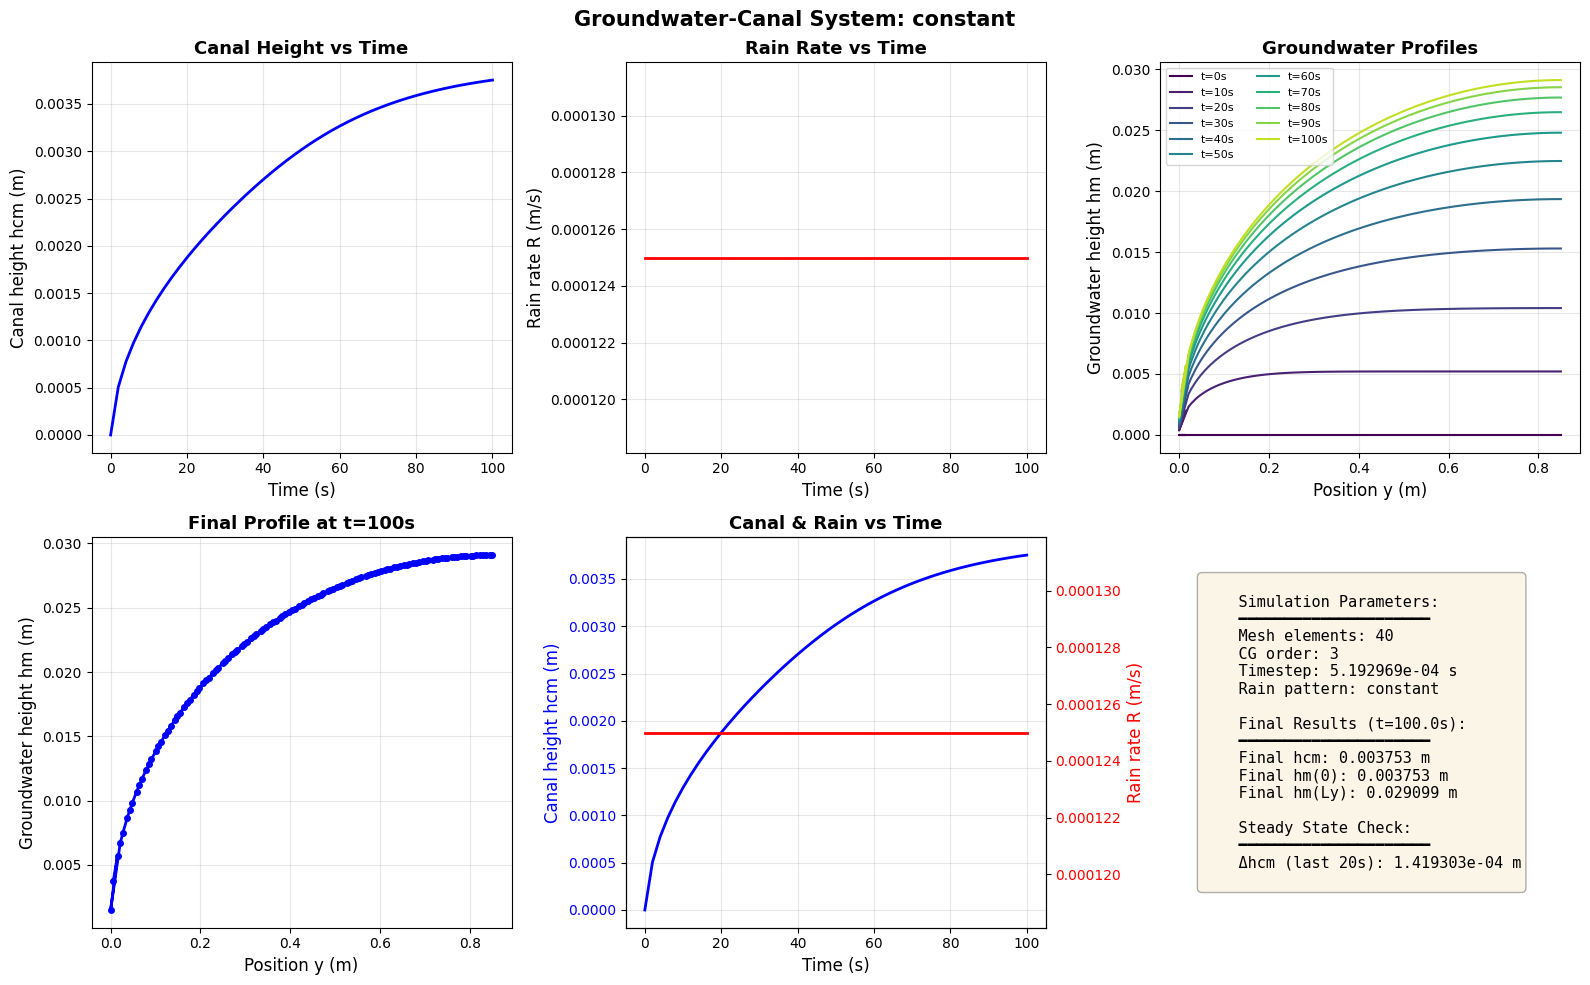

In [11]:
if __name__ == '__main__':

    # Control Flags
    RUN_SIMPLE = True  # Fixed canal problem (hcm = 0.07m)
    RUN_FULL = True    # Full canal problem

    if RUN_SIMPLE:
        print("\n" + "="*70)
        print("SIMPLE PROBLEM: FIXED CANAL HEIGHT (hcm = 0.07m)")
        print("="*70)
        result_simple = solve_groundwater_canal(m=40, nCG=3, theta=0.5, 
                                               end_time=100.0, dt_output=2.0, 
                                               dt_profile=10.0, fixed_canal=True)
        plot_results(result_simple, save_prefix='simple')
    
    if RUN_FULL:
        print("\n" + "="*70)
        print("FULL PROBLEM: COUPLED GROUNDWATER-CANAL")
        print("="*70)
        result_full = solve_groundwater_canal(m=40, nCG=3, theta=0.5,
                                             end_time=100.0, dt_output=2.0,
                                             dt_profile=10.0, fixed_canal=False,
                                             rain_pattern='constant')
        plot_results(result_full, save_prefix='full')

In the simple problem, the solution has reached stedy state after 100 seconds. In the full problem, the solution at the final time has not quite reached steady state, however, it does appear to be close to the steady state solution at the end time given the small rate of change in the solution from the solution after 90 seconds. The full problem has a significantly lower groundwater level at the final time, with a much smaller height at the upstream location (y=0).


COMPARING RAIN PATTERNS


Solving with pattern: constant

Groundwater-Canal System Simulation
Mesh elements: 40, CG order: 3, theta: 0.5
Timestep: 5.192969e-04 s, End time: 100.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: False

t = 10.00s, hcm = 0.001293m, R = 1.250000e-04
t = 20.00s, hcm = 0.001875m, R = 1.250000e-04
t = 30.00s, hcm = 0.002324m, R = 1.250000e-04
t = 40.00s, hcm = 0.002702m, R = 1.250000e-04
t = 50.00s, hcm = 0.003018m, R = 1.250000e-04
t = 60.00s, hcm = 0.003266m, R = 1.250000e-04
t = 70.00s, hcm = 0.003453m, R = 1.250000e-04
t = 80.00s, hcm = 0.003589m, R = 1.250000e-04
t = 90.00s, hcm = 0.003685m, R = 1.250000e-04
t = 100.00s, hcm = 0.003753m, R = 1.250000e-04

Simulation completed in 181.02 seconds (192569 steps)
Final time: 100.00s
Final hcm: 0.003753m
Final hm at y=Ly: 0.029099m


Solving with pattern: intermittent_1

Groundwater-Canal System Simulation
Mesh elements: 40, CG order: 3, theta: 0.5
Timestep: 5.192969e-04 s, End time: 100.0 s
Rain patter

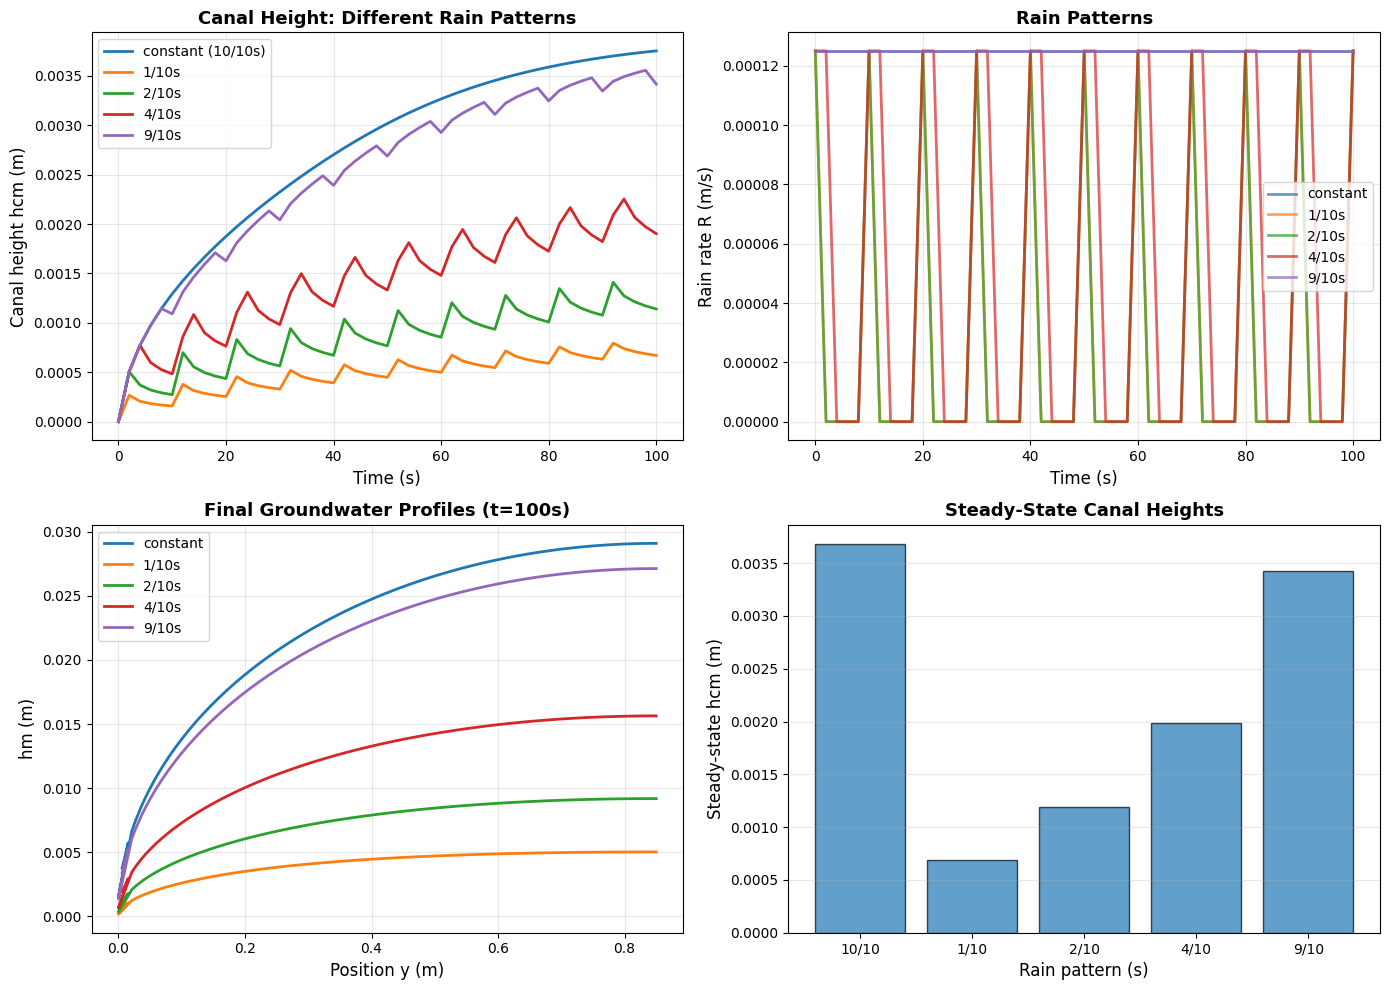

In [12]:
# Main execution
if __name__ == '__main__':
    
    # Control flag
    RUN_RAIN_COMPARISON = True  # Compare rain patterns   
 
    if RUN_RAIN_COMPARISON:
        results_comparison = compare_rain_patterns()

The altered rain profiles show a predictable trend in that the increased time raining causes the groundwater level to increase although it isn't quite proportional to the fraction of time, as a result of the shortened return period after the rain has stopped, this is quite well illustrated by the first figure here. 


CONVERGENCE STUDY

Computing reference solution (m=160)...

Groundwater-Canal System Simulation
Mesh elements: 160, CG order: 3, theta: 0.5
Timestep: 3.245605e-05 s, End time: 10.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: True

t = 10.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 1931.69 seconds (308109 steps)
Final time: 10.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.015220m


Computing solutions for convergence study:

Solving with m=10...

Groundwater-Canal System Simulation
Mesh elements: 10, CG order: 3, theta: 0.5
Timestep: 8.308750e-03 s, End time: 10.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: True

t = 10.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 7.52 seconds (1204 steps)
Final time: 10.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.015222m

  Mesh 10: L2 error = 9.979188e-05, final hcm = 0.070000

Solving with m=20...

Groundwater-Canal System Simulation
Mesh elements: 20, CG order: 3, theta: 0.5
Timestep: 2.077

/tmp/ipykernel_1621/704069935.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error = np.sqrt(np.trapz((hm_test - hm_ref)**2, y_ref))


t = 10.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 30.41 seconds (4815 steps)
Final time: 10.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.015224m

  Mesh 20: L2 error = 3.226769e-05, final hcm = 0.070000

Solving with m=40...

Groundwater-Canal System Simulation
Mesh elements: 40, CG order: 3, theta: 0.5
Timestep: 5.192969e-04 s, End time: 10.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: True



/tmp/ipykernel_1621/704069935.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error = np.sqrt(np.trapz((hm_test - hm_ref)**2, y_ref))


t = 10.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 119.28 seconds (19257 steps)
Final time: 10.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.015219m

  Mesh 40: L2 error = 1.100186e-05, final hcm = 0.070000

Solving with m=80...

Groundwater-Canal System Simulation
Mesh elements: 80, CG order: 3, theta: 0.5
Timestep: 1.298242e-04 s, End time: 10.0 s
Rain pattern: constant, Rmax: 0.000125
Fixed canal: True



/tmp/ipykernel_1621/704069935.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error = np.sqrt(np.trapz((hm_test - hm_ref)**2, y_ref))


t = 10.00s, hcm = 0.070000m, R = 1.250000e-04

Simulation completed in 484.23 seconds (77028 steps)
Final time: 10.00s
Final hcm: 0.070000m
Final hm at y=Ly: 0.015220m

  Mesh 80: L2 error = 4.801141e-06, final hcm = 0.070000

Estimated convergence rate: 1.46


/tmp/ipykernel_1621/704069935.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error = np.sqrt(np.trapz((hm_test - hm_ref)**2, y_ref))


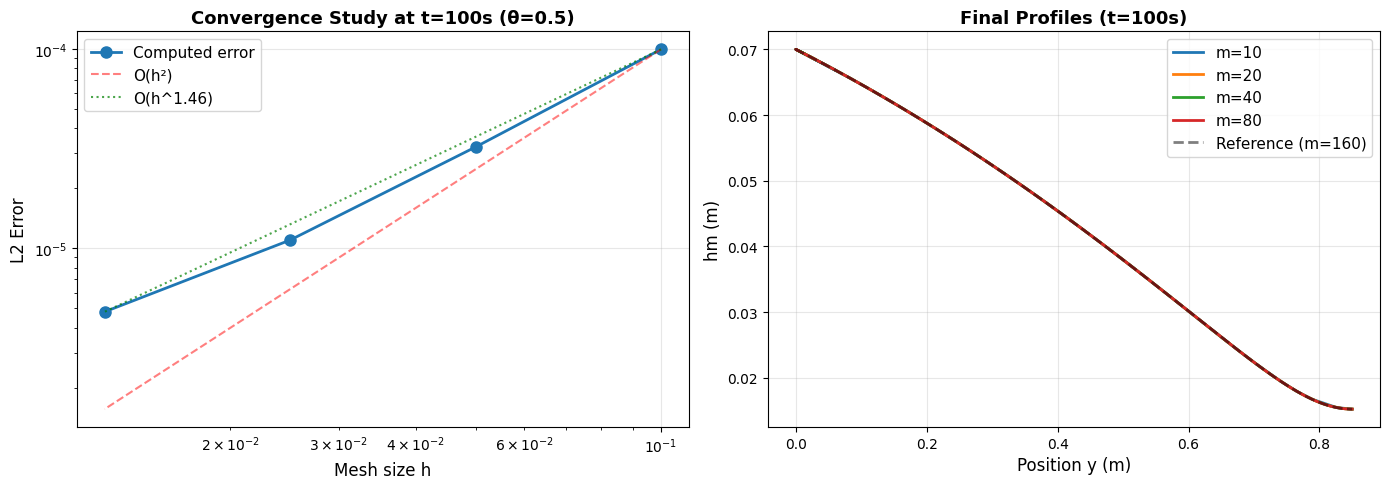


CONVERGENCE STUDY COMPLETE


In [25]:
if __name__ == '__main__':

    RUN_CONVERGENCE = True # Check convergence

    if RUN_CONVERGENCE:
        solutions, errors, h_values = convergence_study(mesh_sizes=[10, 20, 40, 80], 
                                             fixed_canal=True, theta=0.5)

The convergence rate is slightly lower than expected, of 2, which is most likely due to initialisation of the problem and is relatively close. As can be seen from the final solutions, the error is small relative to the solution.

# Crank–Nicolson Discretization for Groundwater–Canal System

## Governing Equation

$$
\frac{\partial h}{\partial t}
= \alpha g \nabla \cdot (h \nabla h)
+ \frac{R}{m_{\text{por}}\,\sigma}
$$

where

- $ h $: groundwater height  
- $ \alpha = \dfrac{k_{\text{perm}}}{\nu\, m_{\text{por}}\, \sigma} $  
- $ R $: rain rate  

---

## Weak Formulation


$$
\int_\Omega \frac{\partial h}{\partial t}\,\phi \, d\Omega
=$$
$$\int_\Omega \alpha g \nabla \cdot (h \nabla h)\,\phi \, d\Omega
+
\int_\Omega \frac{R}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega
$$

### Integration by Parts (Diffusion Term)

$$
\int_\Omega \frac{\partial h}{\partial t}\,\phi \, d\Omega
=$$
$$
-\int_\Omega \alpha g\, h \nabla h \cdot \nabla \phi \, d\Omega
+ \int_{\partial\Omega} \alpha g\, h \frac{\partial h}{\partial n}\,\phi \, dS
+ \int_\Omega \frac{R}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega
$$

---

## Crank–Nicolson Time Discretization $(\theta = 1/2)$

The Crank–Nicolson scheme averages spatial terms between time levels
$n$ and $n+1$:

$$
\begin{aligned}
\int_\Omega \frac{h^{n+1} - h^n}{\Delta t}\,\phi \, d\Omega
=&
-\theta \int_\Omega \alpha g\, h^{n+1} \nabla h^{n+1} \cdot \nabla \phi \, d\Omega \\
&-(1-\theta) \int_\Omega \alpha g\, h^n \nabla h^n \cdot \nabla \phi \, d\Omega \\
&+ \theta \int_\Omega \frac{R^{n+1}}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&+ (1-\theta) \int_\Omega \frac{R^n}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&+ \text{[boundary terms]}
\end{aligned}
$$

### With $(\theta = 1/2)$

$$
\begin{aligned}
\int_\Omega \frac{h^{n+1} - h^n}{\Delta t}\,\phi \, d\Omega
=&
-\frac{1}{2} \int_\Omega \alpha g\, h^{n+1} \nabla h^{n+1} \cdot \nabla \phi \, d\Omega \\
&-\frac{1}{2} \int_\Omega \alpha g\, h^n \nabla h^n \cdot \nabla \phi \, d\Omega \\
&+ \frac{1}{2} \int_\Omega \frac{R^{n+1}}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&+ \frac{1}{2} \int_\Omega \frac{R^n}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&+ \text{[boundary terms]}
\end{aligned}
$$

---

## Boundary Conditions

1. **Top boundary (\(y = L_y\))**  
   Homogeneous Neumann:
   $$
   \frac{\partial h}{\partial n} = 0
   $$
   (satisfied weakly)

2. **Bottom boundary (\(y = 0\)) — canal coupling**

   - Flux across boundary:
     $$
     q = \text{fac2}\,\left(\frac{2h}{3}\right)^{3/2}
     $$

   - Canal equation:
     $$
     \frac{d h_{\text{cm}}}{dt}
     = \frac{1}{L_c}\left(q_{\text{in}} - q_{\text{out}}\right)
     $$

   - Boundary contribution in weak form:
     $$
     \int_{y=0} \left(\gamma \frac{\partial h}{\partial t} + q\right)\phi \, dS = 0
     $$

   where
   $$
   \gamma = \frac{L_c}{m_{\text{por}}\,\sigma}
   $$

---

## Nonlinear System

The term $h^{n+1} \nabla h^{n+1} $ is nonlinear in $ h^{n+1} $.

Define the residual:

$$
\begin{aligned}
F(h^{n+1}) =
&\int_\Omega \frac{h^{n+1} - h^n}{\Delta t}\,\phi \, d\Omega \\
&+ \frac{1}{2} \int_\Omega \alpha g\, h^{n+1} \nabla h^{n+1} \cdot \nabla \phi \, d\Omega \\
&+ \frac{1}{2} \int_\Omega \alpha g\, h^n \nabla h^n \cdot \nabla \phi \, d\Omega \\
&- \frac{1}{2} \int_\Omega \frac{R^{n+1}}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&- \frac{1}{2} \int_\Omega \frac{R^n}{m_{\text{por}}\,\sigma}\,\phi \, d\Omega \\
&+ \text{[boundary terms]}
\end{aligned}
$$

---

## Newton–Raphson Method

To solve
$$
F(h^{n+1}) = 0,
$$
use Newton iteration.

Given an initial guess $h^{n+1,k}$, compute a correction $\delta h$ such that

$$
h^{n+1,k+1} = h^{n+1,k} + \delta h .
$$

The Newton system is

$$
J(h^{n+1,k})\,\delta h = -F(h^{n+1,k}),
$$

where the Jacobian is

$$
J = \frac{\partial F}{\partial h^{n+1}} .
$$

In Firedrake, this Jacobian is assembled automatically using
automatic differentiation.

---

## Convergence Criteria

Newton iteration is considered converged when either

$$
\|F(h^{n+1,k})\| < \text{tol}_{\text{abs}}
\quad \text{or} \quad
\|\delta h\| < \text{tol}_{\text{rel}} .
$$

Typical values:

- $\text{tol}_{\text{abs}} = 10^{-10}$
- $\text{tol}_{\text{rel}} = 10^{-8}$

NB: See Notebook (.ipynb) if LaTeX fails in print.


KEY FINDINGS:
    
### DISCRETIZATION:
- Crank-Nicolson (θ=0.5) provides 2nd-order accuracy in time
- Nonlinear term h∇h requires Newton iteration
       
### CONVERGENCE:
- Typical convergence in 2-4 iterations per timestep
- Quadratic convergence rate near solution
- Residual norms reach machine precision (1e-10)
       
### COMPUTATIONAL EFFICIENCY:
- Fast convergence indicates good initial guess (h^n)
- Crank-Nicolson balances is closer in accuracy to the forward euler solution, but more stable
- Backward Euler (θ=1.0) is more stable but less accurate
    
